In [1]:
# 1

########## 13 February 2019 - Alec S. Hirschauer ##########
# This will be the definitive iPython notebook for identifying
# AGB star candidates in NGC 6822 using a [3.6] vs J-[3.6] CMD
# with data from the Sibbons et al. (2012) WFCAM/UKIRT catalog.
#
# Effectively the THIRD iteration in evolution of this analysis,
# we are attempting to be more considerate of accounting for
# uncertainties in the determination of the color-cut boundaries.
#
# Sundar Srinivasan is currently visiting STScI (22-25 Jan 2019)
# and is helping figure out how to include the photometric
# uncertainties into the KDE analysis.
#
# Future notebooks will be based on this one, but will tackle
# additional CMDs, in no particular order:
# [3.6] vs J-[3.6] <- *THIS ONE*
# [8.0] vs [3.6]-[8.0]
# [24] vs [8.0]-[24]
# [8.0] vs J-[8.0]
# [3.6] vs [3.6]-[4.5]
# [8.0] vs [4.5]-[8.0]
#
# ^ Some of the above may be more or less useful than others,
#   but if we can get the whole process automated, then in
#   principle it wouldn't take much more time to do them all.
#
# The various populations include:
# (1) O-rich/M-type AGB star candidates
# (2) C-rich/C-type AGB star candidates
# (3) the first dusty track of O-rich AGB stars
# (4) extremely dusty sources (included with C-types)
#
# ^ Population (4) is likely some C-types + YSOs
#
# Also NB that we will detect plenty of RSG stars at similar colors
# as the AGB stars, but at lower (brighter) magnitudes.
#
# All this will be accomplished by determining first the TRGB,
# which Cioni & Habing (2005) says is at K_s = 17.10 +/- 0.01
# but Sibbons et al. (2012) says is at K_0 = 17.41 +/- 0.11.
#
# ^ TRGB for this CMD not known from the literature.
#
# I will employ histograms fit with KDE Gaussians to find the
# local minima inflection point over the relevant range of data.
#
# This technique will then also be used to determine the color cuts
# between the various populations as measured by histograms of
# optimum bin width as determined by Knuth's Algorithm.

In [2]:
# 2

# First thing needed is to import the relevant Python libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
# This line is necessary for the number density histograms.
from astropy import stats
from astropy.stats.histogram import knuth_bin_width
# This line is necessary for determining histogram bin width.
from sklearn import neighbors
from scipy.signal import savgol_filter
# These lines are from Sundar's KDE routine

In [3]:
# 3

# Read in my data from a .csv file saved locally.
phot_data = pd.read_csv('CMDKhanANDSibbonsHOME_ahirschauer.csv')
# This is a table of values with 30,745 rows which contains the photometric data of
# the Khan et al. (2015) catalog matched to sources from Sibbons et al. (2012)
# with an "OR" command, then downloaded from MAST CasJobs.
# print phot_data
#
# Also I'll read in the entire Sibbons+ stellar source catalog.
Sibbons_data = pd.read_csv('Sibbons2012NGC6822.csv')
# This is for a test of the histogram(s) I make later on.

In [4]:
# 4

# For the histograms, I have created new .csv files which have the specific colors'
# information: ID, RA, Dec, magnitudes, magnitude errors, color, color error.
#
# I have pre-trimmed the bogus data from these tables already, so there's no need
# to get rid of the whacky 'null' values converted to "-9999" values
# (which, when subtracted from any other value, gives another bogus value)
# like I did in the previous cell with the "full" catalog.
#
jMINUSkDATA = pd.read_csv('jMINUSk.csv')
jMINUSthreesixDATA = pd.read_csv('jMINUSthreesix.csv')
threesixMINUSeightzeroDATA = pd.read_csv('threesixMINUSeightzero.csv')
jMINUSeightzeroDATA = pd.read_csv('jMINUSeightzero.csv')
eightzeroMINUStwentyfourDATA = pd.read_csv('eightzeroMINUStwentyfour.csv')
fourfiveMINUSeightzeroDATA = pd.read_csv('fourfiveMINUSeightzero.csv')
threesixMINUSfourfiveDATA = pd.read_csv('threesixMINUSfourfive.csv')
#
# ^ Note that only the first file is necessary for THIS notebook.

In [5]:
# 5

# The first thing I'll do here is make the J vs J-K CMD & Hess diagram.

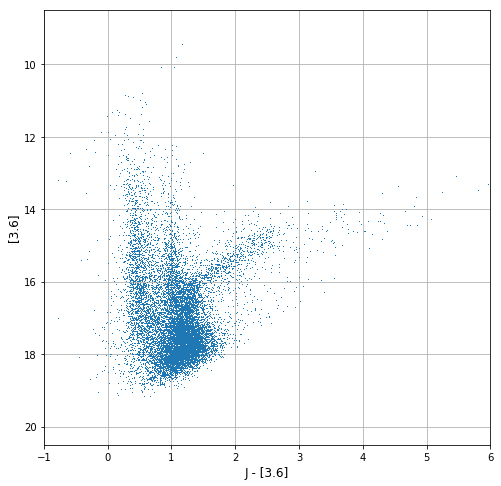

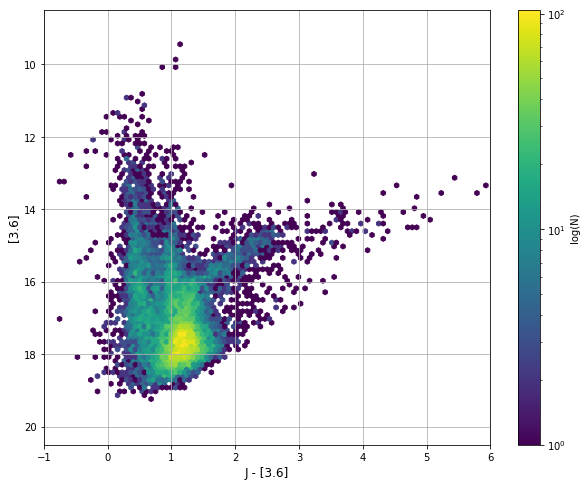

In [6]:
# 6

# [3.6] vs J-[3.6]
# CMD & Hess diagram
#
plt.figure(figsize=(8,8))
plt.plot(jMINUSthreesixDATA.jMINUSthreesix, jMINUSthreesixDATA.k36mag, ',')
plt.xlim(-1.0, 6.0)
#plt.xlim(0.5, 1.75)
plt.ylim(20.5, 8.5)
#plt.ylim(19.5, 15.5)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('[3.6]', size=12)
plt.grid(True)
plt.show()
plt.close()
#plt.savefig('[3.6]_vs_J-[3.6]_plot.pdf')
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-1.0, 6.0)
#plt.xlim(0.5, 1.75)
plt.ylim(20.5, 8.5)
#plt.ylim(19.5, 15.5)
im1 = ax1.hexbin(jMINUSthreesixDATA.jMINUSthreesix, jMINUSthreesixDATA.k36mag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-1.0, 6.0, 20.5, 8.5))
ax1.set_xlabel('J - [3.6]', size=12)
ax1.set_ylabel('[3.6]', size=12)
cb = plt.colorbar(im1, label='log(N)')
plt.grid(True)
plt.show()
plt.close()
#plt.savefig('[3.6]_vs_J-[3.6]_hist.pdf')

In [7]:
# 7

# The second thing I'll do is determine where the TRGB should be.
#
# With the Sibbons+ data I had a reference point, but with the Khan+ data
# I'm starting from scratch.
#
# To do so, I'll isolate only the photometric data of sources with
# errors in the magnitudes less than 0.1.

low_error_jMINUSthreesixDATA = jMINUSthreesixDATA[(jMINUSthreesixDATA.eJmag < 0.1) & (jMINUSthreesixDATA.e36mag < 0.1)]

# And as a check, see what the number of sources is for the entire catalog
# versus the number of sources in this trimmed catalog.

print(len(jMINUSthreesixDATA))
print(len(low_error_jMINUSthreesixDATA))

13743
8533


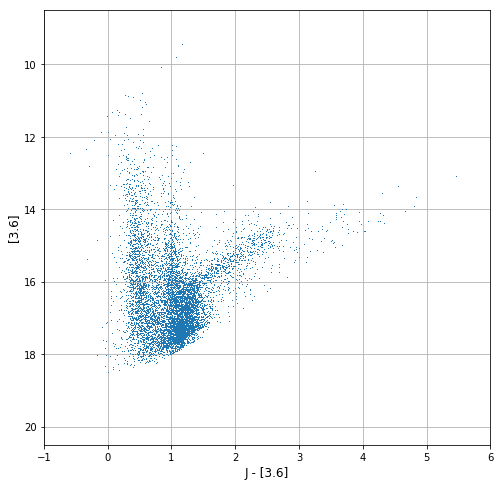

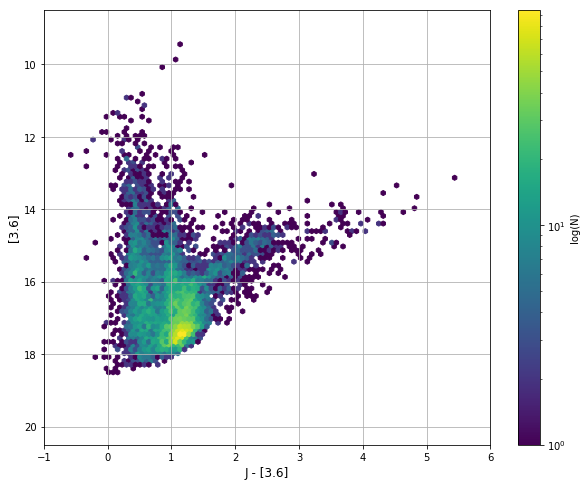

In [8]:
# 8

# With my catalog of only low-error photometry sources, I'll make a
# new CMD and Hess diagram just to see how the data look now.

# [3.6] vs J-[3.6] (low error)
# CMD & Hess diagram
#
plt.figure(figsize=(8,8))
plt.plot(low_error_jMINUSthreesixDATA.jMINUSthreesix, low_error_jMINUSthreesixDATA.k36mag, ',')
plt.xlim(-1.0, 6.0)
#plt.xlim(0.5, 1.75)
plt.ylim(20.5, 8.5)
#plt.ylim(19.5, 15.5)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('[3.6]', size=12)
#plt.savefig('[3.6]_vs_J-[3.6]_plot.pdf')
plt.grid(True)
plt.show()
plt.close()
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-1.0, 6.0)
plt.ylim(20.5, 8.5)
im1 = ax1.hexbin(low_error_jMINUSthreesixDATA.jMINUSthreesix, low_error_jMINUSthreesixDATA.k36mag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-1.0, 6.0, 20.5, 8.5))
ax1.set_xlabel('J - [3.6]', size=12)
ax1.set_ylabel('[3.6]', size=12)
cb = plt.colorbar(im1, label='log(N)')
#plt.savefig('[3.6]_vs_J-[3.6]_hist.pdf')
plt.grid(True)
plt.show()
plt.close()

In [9]:
# 9

# Definitely looks cleaner than before.
#
# I'll use this trimmed catalog to develop the color cuts themselves,
# but the full catalog when I'm doing the actual source identification.
#
##################################################
#
# At this point, the techniques from my previous methodology are going
# to be modified, in the sense that I'll still be implementing a KDE-style
# Gaussian fit to the resulting histograms and finding the values of the
# local minima, but we'll be including the photometric uncertainties into
# the Gaussians to be more statistically robust.
#
# Furthermore, the position of the TRGB itself will now no longer be
# determined by finding a trough in the histogram (and subsequently finding
# the local minimum's position), but instead a technique more similar to how
# Sibbons et al. (2012) found their TRGB. <- *Sobel Edge Detection Technique*
#
# Instead of finding a trough's minimum, they computed where the slope of the
# Gaussian most steeply falls off, which is indicative of where in color space
# there is a rapid change of stellar population demographics.
#
# It has the net effect of including more stars into the range of our boundaries,
# being more consistent with what TRGB value Sibbons+ came up with (which makes
# sense for K vs J-K since it's all only the same photometric data), and since
# determination of this coordinate is automated (based on the fit's derivative),
# finding the TRGB value in all the other CMDs will be more robust AND faster!
#
# In order to determine the color-cut boundaries, however, I have a concern about
# what coordinate value is decided upon:
#
# If it's the edge (where the derivative is maximum), and we're looking for the
# local minima, could we compute the edges for either side, then take an average?
#
# Also, how do I program a Sobel edge detection?
#
# ^ Sundar wrote something based on previous work done by Peter Scicluna.

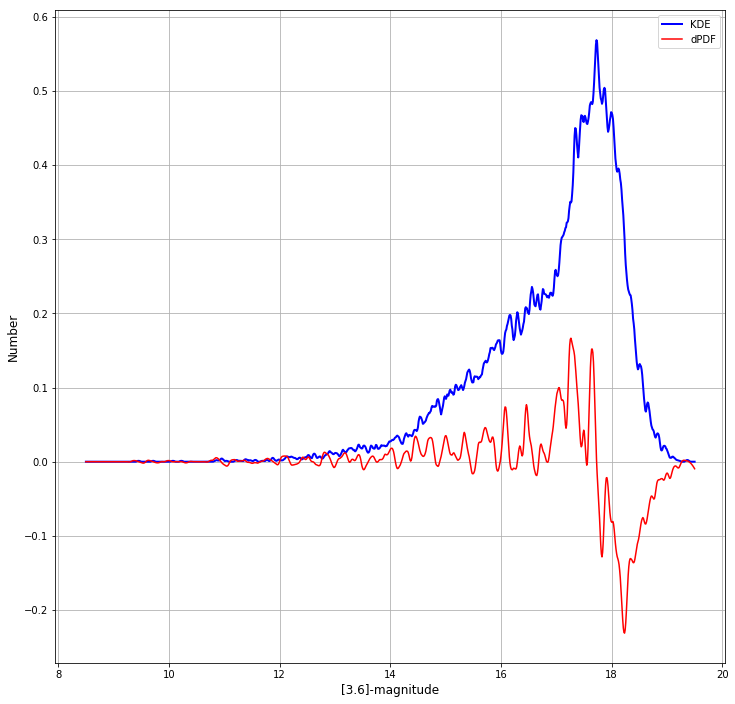

In [10]:
# 10

def getdata():
    infile = 'jMINUSthreesix.csv'
    #table = np.genfromtxt(infile, delimiter = ',')#, dtype = 'i8, f8, f8, f8, f8, f8, f8, f8, f8')
    table = np.genfromtxt(infile, delimiter = ',', skip_header = 1, dtype = \
                          [('ID', 'i8'), ('RA', 'f8'), ('DEC', 'f8'), ('k36mag', 'f8'), ('e36mag', 'f8'), \
                           ('Jmag', 'f8'), ('eJmag', 'f8'), ('jMINUSthreesix', 'f8'), ('ejMINUSthreesix', 'f8')]) 
    m = table['k36mag']
    dm = table['e36mag']
    return m, dm

def doplot(x, pdfx, dpdfx, data = 0):
    plt.figure(figsize = (12,12))
    plt.plot(x, pdfx, 'k', lw = 2., label = 'KDE', color='blue')
#    if data != 0:
#        plt.hist(data, bins = bins, normed = True, label = 'Binned data')
#    plt.xlim(xlim)
    plt.plot(x, dpdfx*20, 'k', lw = 1.5, label = 'dPDF', color='red')
    plt.legend()
    plt.xlabel('[3.6]-magnitude', size=12)
    plt.ylabel('Number', size=12)
    plt.grid(True)
    plt.show()
    plt.close()

def main():

    #Read from input table into variables m and dm
    m, dm = getdata()

    #Initialise stuff
    rtol = 1e-5
    kernel = 'epanechnikov' #parabolic kernel
    #mx = np.linspace(min(m)*0.8, max(m)*1.2, 1000)
    mx = np.linspace(8.5, 19.5, 1000)
    #Generate NITER realisations of the KDE

#    for i in range(niter):
    msamp = np.random.normal(m, dm)
    #print(min(msamp))
        #PS: Monte Carlo already smooths the distribution, so reduce the ideal binwidth a bit.
    bandwidth_factor = 0.25
    bandwidth = bandwidth_factor*(np.std(msamp)*(len(msamp)**(-0.2)))
        #Requires you to define the BANDWIDTH and KERNEL variables before this line.
    kde = neighbors.KernelDensity(bandwidth = bandwidth, rtol = rtol, kernel = kernel)
    kde.fit(msamp[:, np.newaxis])
        #MX is the x axis range over which the PDF is computed/plotted.
    pdf = kde.score_samples(mx[:, np.newaxis])
    pdf = np.exp(pdf)
    dpdf = np.gradient(pdf, mx[1] - mx[0]) #mx is equally spaced, provide the spacing as the x difference.
    from scipy.signal import savgol_filter
    pdfsm = savgol_filter(pdf, 3, 2, deriv = 0)
    dpdfsm = savgol_filter(pdf, 31, 3, deriv = 1) #smoothing window should be somehow related to resolution used for x axis
 #       #Plotting
    doplot(mx, pdf, dpdfsm)
    #print(pdf)
    #print(bandwidth)
 #       #Use PDF to do stuff (e.g., detect edges)
 #       #result = do_stuff(pdf)
 #       #Store results of ith iteration
 #       #
 #       #

main()


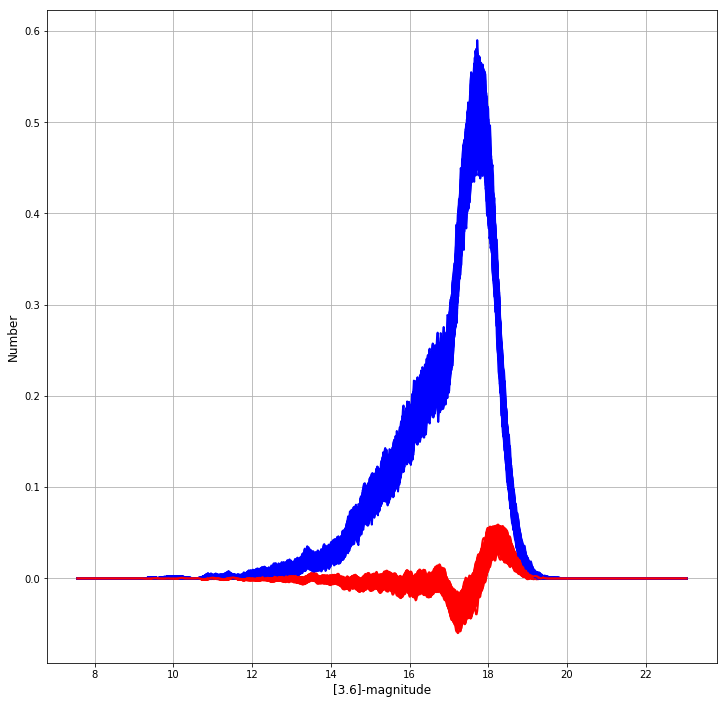

(17.24410294294295, 0.08464318915355873)

In [11]:
# 11

import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors
from scipy.signal import savgol_filter

def getdata(infile = 'jMINUSthreesix.csv', magname = 'k36mag', dmagname = 'e36mag'):
    #table = np.genfromtxt(infile, delimiter = ',')#, dtype = 'i8, f8, f8, f8, f8, f8, f8, f8, f8')
    table = np.genfromtxt(infile, delimiter = ',', skip_header = 1, dtype = \
                          [('ID', 'i8'), ('RA', 'f8'), ('DEC', 'f8'), ('k36mag', 'f8'), ('e36mag', 'f8'), \
                           ('Jmag', 'f8'), ('eJmag', 'f8'), ('jMINUSthreesix', 'f8'), ('ejMINUSthreesix', 'f8')]) 
    m = table['k36mag']
    dm = table['e36mag']
    return m, dm

def doplot(x, pdfx, deriv = 0, data = 0, first = True, last = False):
    if first: plt.figure(figsize = (12,12))
    plt.plot(x, pdfx, 'k', lw = 2, label = 'KDE', color='blue')
    #if len(data) != 1 and data[0] != 0:
    #    plt.hist(data, bins = bins, normed = True, label = 'Binned data')
    try:
        scale = np.max(pdfx)/np.max(deriv)/10.
        plt.plot(x, deriv*scale, 'r', lw = 2, label = 'dKDE', color='red')
    except:
        print('no derivatives specified')
    if last:
        plt.xlabel('[3.6]-magnitude', size=12)
        plt.ylabel('Number', size=12)
        plt.grid(True)
        plt.show()
        plt.close()
    #if len(deriv) != 1 and deriv[0] != 0:
    #    scale = np.max(pdfx)/np.max(deriv)
    #    print(scale)
    #    plt.plot(x, deriv*scale, 'k', lw = 3, label = 'dKDE')
    #    #plt.plot(x, deriv, 'r', lw = 2, label = 'dKDE')

def trgbfind(infile = 'jMINUSthreesix.csv', magname = 'k36mag', dmagname = 'e36mag', niter = 1000, kernel = 'epanechnikov'):

    #Read from input table into variables m and dm
    m, dm = getdata(infile = infile)

    #Initialise stuff
    niter = 1000
    rtol = 1e-5
    kernel = 'epanechnikov' #parabolic kernel
    mx = np.linspace(max(m)*1.2, min(m)*0.8, 1000)
    trgbloc = np.zeros(niter)
    #Generate NITER realisations of the KDE

    for i in range(niter):
        msamp = np.random.normal(m, dm)
        #PS: Monte Carlo already smooths the distribution, so reduce the ideal binwidth a bit.
        bandwidth_factor = 0.25
        bandwidth = bandwidth_factor*(np.std(msamp)*(len(msamp)**(-0.2)))
        #Requires you to define the BANDWIDTH and KERNEL variables before this line.
        kde = neighbors.KernelDensity(bandwidth = bandwidth, rtol = rtol, kernel = kernel)
        kde.fit(msamp[:, np.newaxis])
        #MX is the x axis range over which the PDF is computed/plotted.
        #kde.score_samples returns ln(pdf)
        pdf = np.exp(kde.score_samples(mx[:, np.newaxis]))
        smooth_window = 31
        poly_degree = 3
        dpdf = savgol_filter(pdf, smooth_window, poly_degree, deriv = 1)
        trgbloc[i] = mx[np.argmin(dpdf)] #Most negative value corresponds to highest rate of decrease 
        #Plotting
        doplot(mx, pdf, deriv = dpdf, data = msamp, first = i == 0, last = i == niter - 1)
        #Use PDF to do stuff (e.g., detect edges)
        #result = do_stuff(pdf)
        #Store results of ith iteration
        #
        #

    trgbloc_mean = np.mean(trgbloc)
    trgbloc_sd = np.std(trgbloc)
    return trgbloc_mean, trgbloc_sd
    #print(trgbloc_mean, trgbloc_sd) # this does the same as the above, just differently

trgbfind()


In [12]:
# 12

# KDE and edge-detection stuff aside, I still need to program the
# progressive bin sizes part of the process.
#
# (1) Once the TRGB (with uncertainties) is established, use this
# y-axis value ([3.6]-band in this case) as a starting point.
# 
# (2) Starting at the TRGB value, restrict the catalog of sources
# between the start value to some arbitrary value (say, [3.6] = 17.244
# to [3.6] = 17.244 + 0.250 = 17.494).
# 
# (3) Print the length of this list.  If it’s longer than a set
# value (say, N = 1000?), reduce the range by some small increment
# (say, K = 17.244 to K = 17.244 + 0.249 = 17.493) and print the
# length of the list again.  Repeat until you hit the target threshold.
#
# Sundar's comment on (3): I thought the idea was to have a *minimum* length
# to ensure we don't have too few data points in the bin? Step (3) should start
# with a default bin size, check whether N < 1000 and, if so, increase the bin size
# for this bin. Repeat procedure until N >= 1000.
#
# [NB: once we get high up on the CMD, even a 0.250 dex span won’t
# encompass our desired number of sources, so maybe this range should
# initially be higher?]
#
# Sundar's comment: Yes, at the very top of the CMD, the bin size will end up being huge.
# This is fine, since we will need a minimum number of points to say something concrete
# about the cut at this level anyway. One possible way to work on this would be as follows:
# 1) At the start of the procedure, initialise a variable that will contain the total number
# of points brighter than the current bin edge. At the beginning of the iterations, this
# variable will contain the total number of sources brighter than the K-band TRGB value. As
# you gradually proceed up the K-band in brightness, the total number of sources brighter
# than this K-band magnitude will decrease. When the number falls below the minimum number
# desired in each bin, then you know the iterations must also cease. This automatically decides
# where the last bin is located, and also how wide it will be.
#
# (4) Once we get a range of y-axis values than encompasses our target
# number of sources, run the KDE routine you wrote out to get the
# Gaussian (or Epanechnikov or whatever) fit to the data.
#
# (5) Run the Sobel edge filter part of the routine to determine the 
# maximum derivative(s) of the fit, which signify the steepest areas
# of the fit, and therefore breaks in the populations.
# In order to determine where the *local minima* are, I suggest
# determining where these are and taking an average of the two locations
# (where the slopes are) and using that to set where the trough of
# a given minimum is.
#
# You had talked about using some high threshold at first to determine
# the *most* maximum derivative, then progressively relaxing this value
# to find other ones.  How might we implement that?
#
# Sundar's comment on #5: While the Sobel filter was used in previous studies, the current
# implementation of our code uses a Savitzky-Golay filter to compute the first derivative. The
# highest-magnitude derivative will be easy to find, but beyond that we will have to be careful.
# I don't know yet what "being careful" entails in this case.
#
# (6) Repeat steps (3) through (5), recording said values somewhere,
# until you reach the end of the CMD’s available sources.
#
# (7) Using these values, representing points along the CMDs, construct
# linear fits to make the color-cut boundaries.
#
# (8) Segregate out the sources within the given boundaries to create
# lists of foreground/MS stars, O-rich AGB star candidates,
# C-rich AGB star candidates, etc., and save those lists.
# 
# (9) Repeat the above steps for the next CMD ([3.6] vs. J – [3.6],
# for example) and compare the resulting lists against one another.


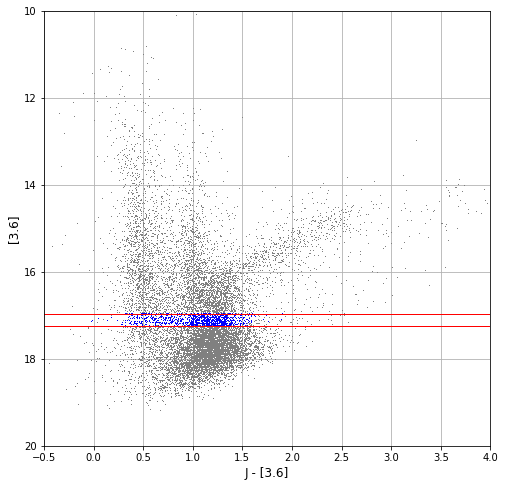

1013
0.07684
17.244
16.964


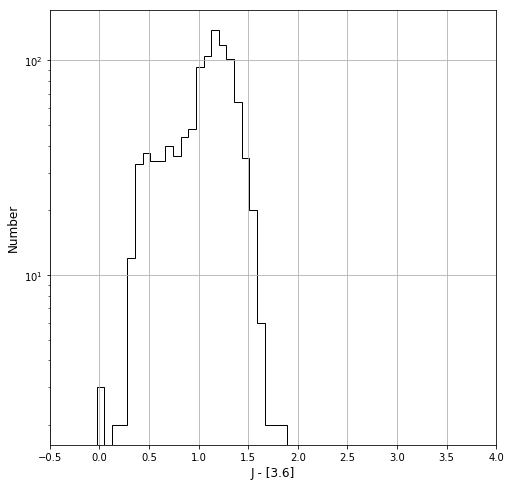

In [67]:
# 13 (Bin 1)

# Here I'm making the CMD of *ONLY* the sources within the first bin above the TRGB.
# Also I'm making a histogram of said sources.

TRGB = 17.244
initial_width = 0.500
width_change = 0.010

jMINUSthreesixHIST = low_error_jMINUSthreesixDATA[(low_error_jMINUSthreesixDATA.k36mag < (TRGB))
                                    & (low_error_jMINUSthreesixDATA.k36mag > (TRGB-initial_width*1.+width_change*22.))]

bin_end = TRGB-initial_width*1.+width_change*22.

plt.figure(figsize=(8,8))
plt.plot(jMINUSthreesixDATA.jMINUSthreesix, jMINUSthreesixDATA.k36mag, ',', color='gray')
plt.plot(jMINUSthreesixHIST.jMINUSthreesix, jMINUSthreesixHIST.k36mag, ',', color='blue')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('[3.6]', size=12)
#
plt.axhline(y=TRGB, linewidth=1.0, color='red') # Bin 1 - lower boundary
plt.axhline(y=bin_end, linewidth=1.0, color='red') # Bin 1 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
#print jMINUSkHIST
print(len(jMINUSthreesixHIST))
#
binwidth = stats.knuth_bin_width(jMINUSthreesixHIST.jMINUSthreesix)
bin_number = (max(jMINUSthreesixHIST.jMINUSthreesix)+binwidth)/binwidth
print(binwidth)
#print bin_number
#
print(TRGB)
print(bin_end)
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSthreesixHIST.jMINUSthreesix, bins=np.arange(min(jMINUSthreesixHIST.jMINUSthreesix), max(jMINUSthreesixHIST.jMINUSthreesix) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

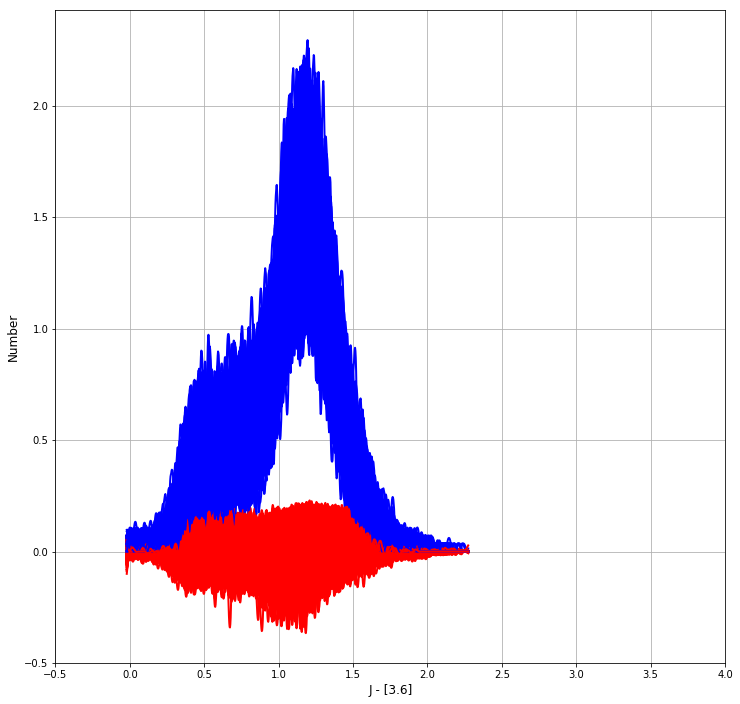

(1.067736886886887, 0.14912932995751546)

In [68]:
# 14 (Bin 1)

def doplot(x, pdfx, deriv = 0, data = 0, first = True, last = False):
    if first: plt.figure(figsize = (12,12))
    plt.plot(x, pdfx, 'k', lw = 2, label = 'KDE', color='blue')
    #if len(data) != 1 and data[0] != 0:
    #    plt.hist(data, bins = bins, normed = True, label = 'Binned data')
    try:
        scale = np.max(pdfx)/np.max(deriv)/10.
        plt.plot(x, deriv*scale, 'r', lw = 2, label = 'dKDE', color='red')
    except:
        print('no derivatives specified')
    if last:
        plt.xlim(-0.5, 4.0)
        plt.xlabel('J - [3.6]', size=12)
        plt.ylabel('Number', size=12)
        plt.grid(True)
        plt.show()
        plt.close()
    #if len(deriv) != 1 and deriv[0] != 0:
    #    scale = np.max(pdfx)/np.max(deriv)
    #    print(scale)
    #    plt.plot(x, deriv*scale, 'k', lw = 3, label = 'dKDE')
    #    #plt.plot(x, deriv, 'r', lw = 2, label = 'dKDE')

def trgbfind(infile = 'jMINUSthreesix.csv', magname = 'k36mag', dmagname = 'e36mag', niter = 1000, kernel = 'epanechnikov'):

    #Read from input table into variables m and dm
#    m, dm = getdata(infile = infile)

    ### Can I skip all the "infile" stuff? -> YES!
    #m = jMINUSthreesixDATA.k36mag
    #dm = jMINUSthreesixDATA.e36mag

    ### Instead of TRGB, let's try the small range of magnitudes
    m = jMINUSthreesixHIST.jMINUSthreesix
    dm = jMINUSthreesixHIST.ERRORjMINUSthreesix
    
    #Initialise stuff
    niter = 1000
    rtol = 1e-5
    kernel = 'epanechnikov' #parabolic kernel
    mx = np.linspace(max(m)*1.2, min(m)*0.8, 1000)
    trgbloc = np.zeros(niter)
    #Generate NITER realisations of the KDE

    for i in range(niter):
        msamp = np.random.normal(m, dm)
        #PS: Monte Carlo already smooths the distribution, so reduce the ideal binwidth a bit.
        bandwidth_factor = 0.25
        bandwidth = bandwidth_factor*(np.std(msamp)*(len(msamp)**(-0.2)))
        #Requires you to define the BANDWIDTH and KERNEL variables before this line.
        kde = neighbors.KernelDensity(bandwidth = bandwidth, rtol = rtol, kernel = kernel)
        kde.fit(msamp[:, np.newaxis])
        #MX is the x axis range over which the PDF is computed/plotted.
        #kde.score_samples returns ln(pdf)
        pdf = np.exp(kde.score_samples(mx[:, np.newaxis]))
        smooth_window = 31
        poly_degree = 3
        dpdf = savgol_filter(pdf, smooth_window, poly_degree, deriv = 1)
        trgbloc[i] = mx[np.argmin(dpdf)] #Most negative value corresponds to highest rate of decrease 
        #Plotting
        doplot(mx, pdf, deriv = dpdf, data = msamp, first = i == 0, last = i == niter - 1)
        #Use PDF to do stuff (e.g., detect edges)
        #result = do_stuff(pdf)
        #Store results of ith iteration
        #
        #

    trgbloc_mean = np.mean(trgbloc)
    trgbloc_sd = np.std(trgbloc)
    return trgbloc_mean, trgbloc_sd
    #print(trgbloc_mean, trgbloc_sd) # this does the same as the above, just differently

trgbfind()


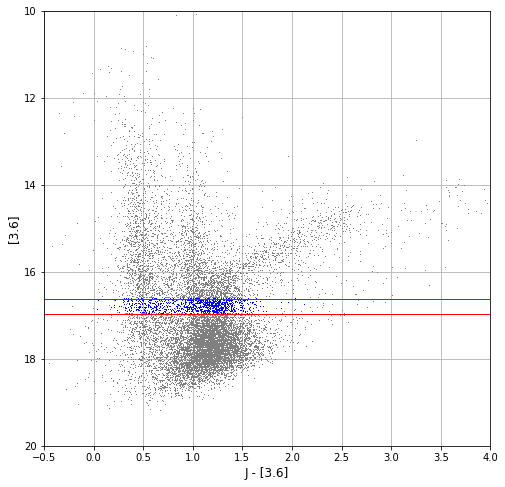

1008
0.08679166666666667
16.964
16.613999999999997


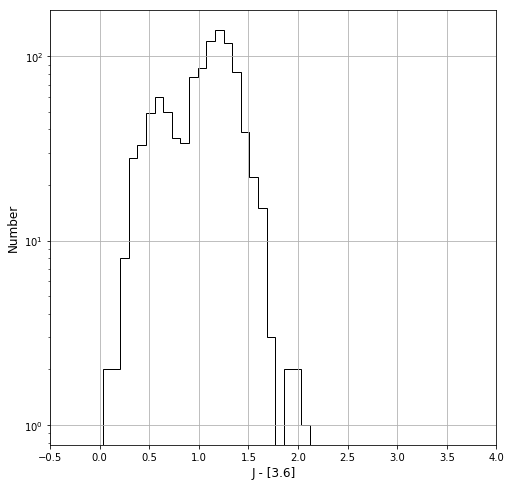

In [69]:
# 15 (Bin 2)

# Here I'm making the CMD of *ONLY* the sources within the second bin above the TRGB.
# Also I'm making a histogram of said sources.

#TRGB = 17.386
#initial_width = 0.500
#width_change = 0.010

TRGB = 16.964

jMINUSthreesixHIST = low_error_jMINUSthreesixDATA[(low_error_jMINUSthreesixDATA.k36mag < (TRGB))
                                    & (low_error_jMINUSthreesixDATA.k36mag > (TRGB-initial_width*1.+width_change*15.))]

bin_end = TRGB-initial_width*1.+width_change*15.

plt.figure(figsize=(8,8))
plt.plot(jMINUSthreesixDATA.jMINUSthreesix, jMINUSthreesixDATA.k36mag, ',', color='gray')
plt.plot(jMINUSthreesixHIST.jMINUSthreesix, jMINUSthreesixHIST.k36mag, ',', color='blue')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('[3.6]', size=12)
#
plt.axhline(y=TRGB, linewidth=1.0, color='red') # Bin 2 - lower boundary
plt.axhline(y=bin_end, linewidth=1.0, color='red') # Bin 2 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
#print jMINUSthreesixHIST
print(len(jMINUSthreesixHIST))
#
binwidth = stats.knuth_bin_width(jMINUSthreesixHIST.jMINUSthreesix)
bin_number = (max(jMINUSthreesixHIST.jMINUSthreesix)+binwidth)/binwidth
print(binwidth)
#print bin_number
#
print(TRGB)
print(bin_end)
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSthreesixHIST.jMINUSthreesix, bins=np.arange(min(jMINUSthreesixHIST.jMINUSthreesix), max(jMINUSthreesixHIST.jMINUSthreesix) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

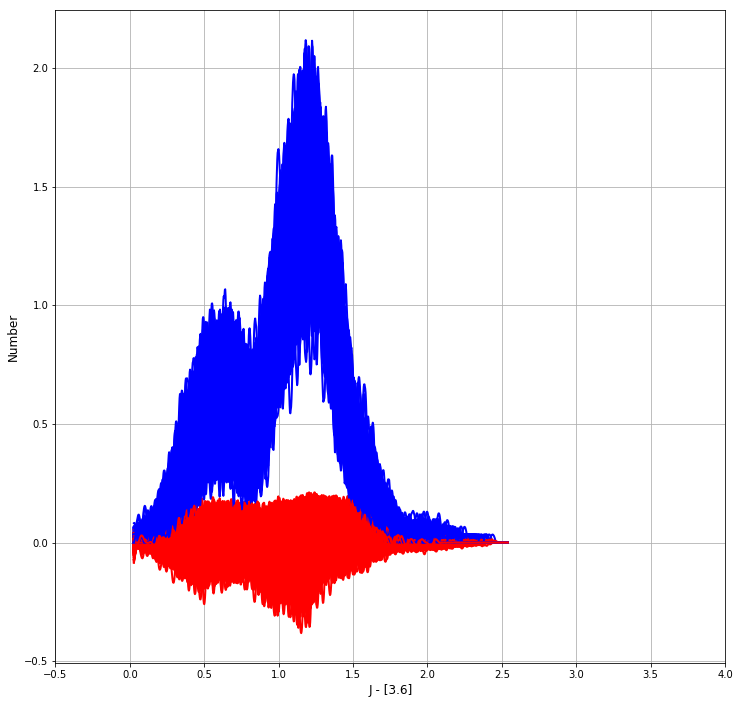

(1.0587415563563563, 0.18166563901494018)

In [66]:
# 16 (Bin 2)

def doplot(x, pdfx, deriv = 0, data = 0, first = True, last = False):
    if first: plt.figure(figsize = (12,12))
    plt.plot(x, pdfx, 'k', lw = 2, label = 'KDE', color='blue')
    #if len(data) != 1 and data[0] != 0:
    #    plt.hist(data, bins = bins, normed = True, label = 'Binned data')
    try:
        scale = np.max(pdfx)/np.max(deriv)/10.
        plt.plot(x, deriv*scale, 'r', lw = 2, label = 'dKDE', color='red')
    except:
        print('no derivatives specified')
    if last:
        plt.xlim(-0.5, 4.0)
        plt.xlabel('J - [3.6]', size=12)
        plt.ylabel('Number', size=12)
        plt.grid(True)
        plt.show()
        plt.close()
    #if len(deriv) != 1 and deriv[0] != 0:
    #    scale = np.max(pdfx)/np.max(deriv)
    #    print(scale)
    #    plt.plot(x, deriv*scale, 'k', lw = 3, label = 'dKDE')
    #    #plt.plot(x, deriv, 'r', lw = 2, label = 'dKDE')

def trgbfind(infile = 'jMINUSthreesix.csv', magname = 'k36mag', dmagname = 'e36mag', niter = 1000, kernel = 'epanechnikov'):

    #Read from input table into variables m and dm
#    m, dm = getdata(infile = infile)

    ### Can I skip all the "infile" stuff? -> YES!
    #m = jMINUSthreesixDATA.k36mag
    #dm = jMINUSthreesixDATA.e36mag

    ### Instead of TRGB, let's try the small range of magnitudes
    m = jMINUSthreesixHIST.jMINUSthreesix
    dm = jMINUSthreesixHIST.ERRORjMINUSthreesix
    
    #Initialise stuff
    niter = 1000
    rtol = 1e-5
    kernel = 'epanechnikov' #parabolic kernel
    mx = np.linspace(max(m)*1.2, min(m)*0.8, 1000)
    trgbloc = np.zeros(niter)
    #Generate NITER realisations of the KDE

    for i in range(niter):
        msamp = np.random.normal(m, dm)
        #PS: Monte Carlo already smooths the distribution, so reduce the ideal binwidth a bit.
        bandwidth_factor = 0.25
        bandwidth = bandwidth_factor*(np.std(msamp)*(len(msamp)**(-0.2)))
        #Requires you to define the BANDWIDTH and KERNEL variables before this line.
        kde = neighbors.KernelDensity(bandwidth = bandwidth, rtol = rtol, kernel = kernel)
        kde.fit(msamp[:, np.newaxis])
        #MX is the x axis range over which the PDF is computed/plotted.
        #kde.score_samples returns ln(pdf)
        pdf = np.exp(kde.score_samples(mx[:, np.newaxis]))
        smooth_window = 31
        poly_degree = 3
        dpdf = savgol_filter(pdf, smooth_window, poly_degree, deriv = 1)
        trgbloc[i] = mx[np.argmin(dpdf)] #Most negative value corresponds to highest rate of decrease 
        #Plotting
        doplot(mx, pdf, deriv = dpdf, data = msamp, first = i == 0, last = i == niter - 1)
        #Use PDF to do stuff (e.g., detect edges)
        #result = do_stuff(pdf)
        #Store results of ith iteration
        #
        #

    trgbloc_mean = np.mean(trgbloc)
    trgbloc_sd = np.std(trgbloc)
    return trgbloc_mean, trgbloc_sd
    #print(trgbloc_mean, trgbloc_sd) # this does the same as the above, just differently

trgbfind()


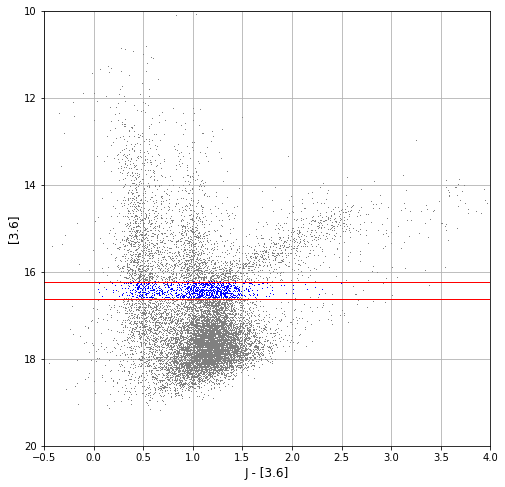

1000
0.09407692307692309
16.614
16.234


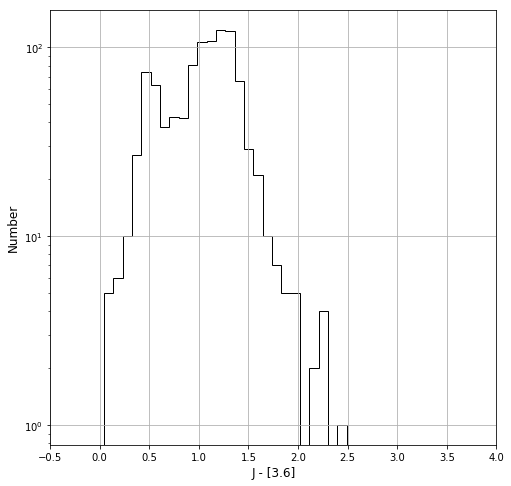

In [71]:
# 17 (Bin 3)

# Here I'm making the CMD of *ONLY* the sources within the third bin above the TRGB.
# Also I'm making a histogram of said sources.

#TRGB = 17.386
#initial_width = 0.500
#width_change = 0.010

TRGB = 16.614

jMINUSthreesixHIST = low_error_jMINUSthreesixDATA[(low_error_jMINUSthreesixDATA.k36mag < (TRGB))
                                    & (low_error_jMINUSthreesixDATA.k36mag > (TRGB-initial_width*1.+width_change*12.))]

bin_end = TRGB-initial_width*1.+width_change*12.

plt.figure(figsize=(8,8))
plt.plot(jMINUSthreesixDATA.jMINUSthreesix, jMINUSthreesixDATA.k36mag, ',', color='gray')
plt.plot(jMINUSthreesixHIST.jMINUSthreesix, jMINUSthreesixHIST.k36mag, ',', color='blue')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('[3.6]', size=12)
#
plt.axhline(y=TRGB, linewidth=1.0, color='red') # Bin 3 - lower boundary
plt.axhline(y=bin_end, linewidth=1.0, color='red') # Bin 3 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
#print jMINUSthreesixHIST
print(len(jMINUSthreesixHIST))
#
binwidth = stats.knuth_bin_width(jMINUSthreesixHIST.jMINUSthreesix)
bin_number = (max(jMINUSthreesixHIST.jMINUSthreesix)+binwidth)/binwidth
print(binwidth)
#print bin_number
#
print(TRGB)
print(bin_end)
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSthreesixHIST.jMINUSthreesix, bins=np.arange(min(jMINUSthreesixHIST.jMINUSthreesix), max(jMINUSthreesixHIST.jMINUSthreesix) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

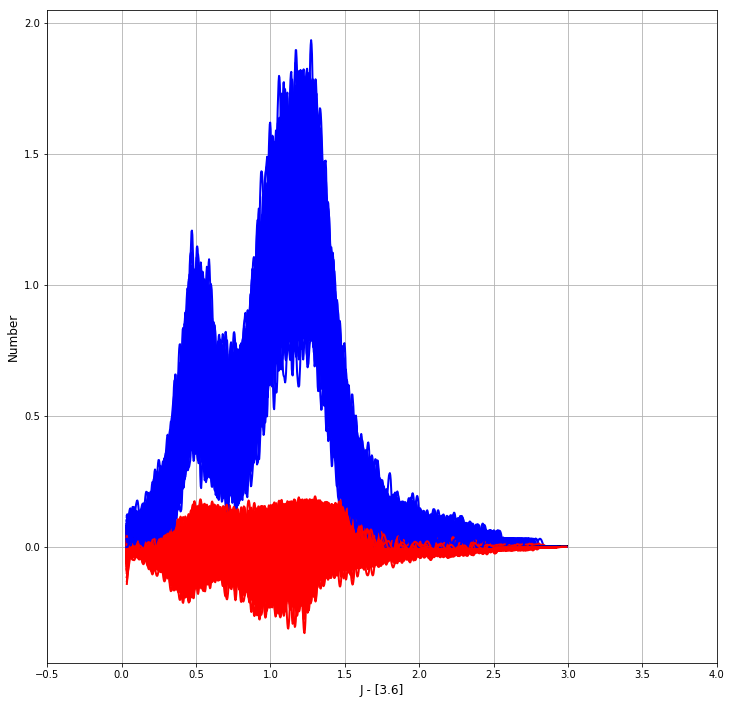

(0.9962551167167167, 0.23786076723181465)

In [72]:
# 18 (Bin 3)

def doplot(x, pdfx, deriv = 0, data = 0, first = True, last = False):
    if first: plt.figure(figsize = (12,12))
    plt.plot(x, pdfx, 'k', lw = 2, label = 'KDE', color='blue')
    #if len(data) != 1 and data[0] != 0:
    #    plt.hist(data, bins = bins, normed = True, label = 'Binned data')
    try:
        scale = np.max(pdfx)/np.max(deriv)/10.
        plt.plot(x, deriv*scale, 'r', lw = 2, label = 'dKDE', color='red')
    except:
        print('no derivatives specified')
    if last:
        plt.xlim(-0.5, 4.0)
        plt.xlabel('J - [3.6]', size=12)
        plt.ylabel('Number', size=12)
        plt.grid(True)
        plt.show()
        plt.close()
    #if len(deriv) != 1 and deriv[0] != 0:
    #    scale = np.max(pdfx)/np.max(deriv)
    #    print(scale)
    #    plt.plot(x, deriv*scale, 'k', lw = 3, label = 'dKDE')
    #    #plt.plot(x, deriv, 'r', lw = 2, label = 'dKDE')

def trgbfind(infile = 'jMINUSthreesix.csv', magname = 'k36mag', dmagname = 'e36mag', niter = 1000, kernel = 'epanechnikov'):

    #Read from input table into variables m and dm
#    m, dm = getdata(infile = infile)

    ### Can I skip all the "infile" stuff? -> YES!
    #m = jMINUSthreesixDATA.k36mag
    #dm = jMINUSthreesixDATA.e36mag

    ### Instead of TRGB, let's try the small range of magnitudes
    m = jMINUSthreesixHIST.jMINUSthreesix
    dm = jMINUSthreesixHIST.ERRORjMINUSthreesix
    
    #Initialise stuff
    niter = 1000
    rtol = 1e-5
    kernel = 'epanechnikov' #parabolic kernel
    mx = np.linspace(max(m)*1.2, min(m)*0.8, 1000)
    trgbloc = np.zeros(niter)
    #Generate NITER realisations of the KDE

    for i in range(niter):
        msamp = np.random.normal(m, dm)
        #PS: Monte Carlo already smooths the distribution, so reduce the ideal binwidth a bit.
        bandwidth_factor = 0.25
        bandwidth = bandwidth_factor*(np.std(msamp)*(len(msamp)**(-0.2)))
        #Requires you to define the BANDWIDTH and KERNEL variables before this line.
        kde = neighbors.KernelDensity(bandwidth = bandwidth, rtol = rtol, kernel = kernel)
        kde.fit(msamp[:, np.newaxis])
        #MX is the x axis range over which the PDF is computed/plotted.
        #kde.score_samples returns ln(pdf)
        pdf = np.exp(kde.score_samples(mx[:, np.newaxis]))
        smooth_window = 31
        poly_degree = 3
        dpdf = savgol_filter(pdf, smooth_window, poly_degree, deriv = 1)
        trgbloc[i] = mx[np.argmin(dpdf)] #Most negative value corresponds to highest rate of decrease 
        #Plotting
        doplot(mx, pdf, deriv = dpdf, data = msamp, first = i == 0, last = i == niter - 1)
        #Use PDF to do stuff (e.g., detect edges)
        #result = do_stuff(pdf)
        #Store results of ith iteration
        #
        #

    trgbloc_mean = np.mean(trgbloc)
    trgbloc_sd = np.std(trgbloc)
    return trgbloc_mean, trgbloc_sd
    #print(trgbloc_mean, trgbloc_sd) # this does the same as the above, just differently

trgbfind()


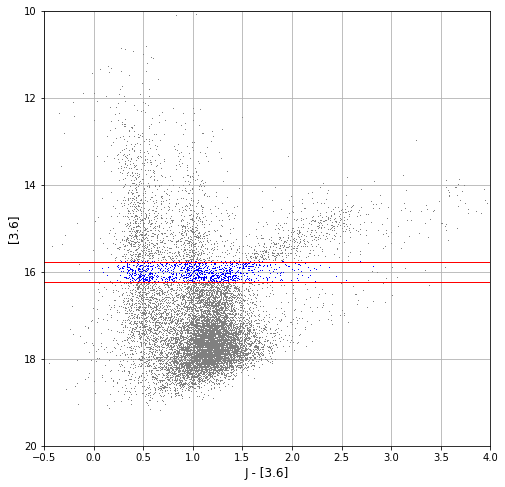

1005
0.12421739130434782
16.234
15.764000000000001


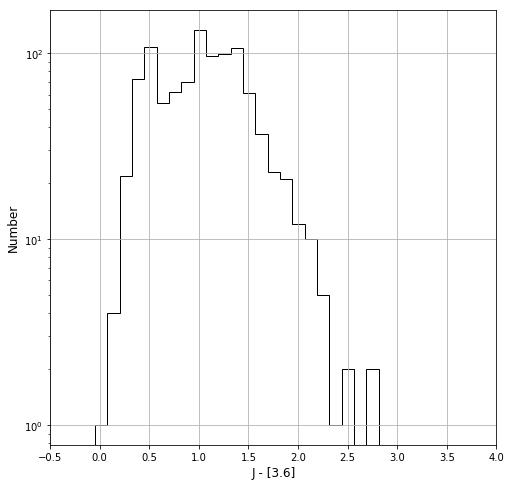

In [19]:
# 19 (Bin 4)

# Here I'm making the CMD of *ONLY* the sources within the fourth bin above the TRGB.
# Also I'm making a histogram of said sources.

#TRGB = 17.386
#initial_width = 0.500
#width_change = 0.010

TRGB = 16.234

jMINUSthreesixHIST = low_error_jMINUSthreesixDATA[(low_error_jMINUSthreesixDATA.k36mag < (TRGB))
                                    & (low_error_jMINUSthreesixDATA.k36mag > (TRGB-initial_width*1.+width_change*3.))]

bin_end = TRGB-initial_width*1.+width_change*3.

plt.figure(figsize=(8,8))
plt.plot(jMINUSthreesixDATA.jMINUSthreesix, jMINUSthreesixDATA.k36mag, ',', color='gray')
plt.plot(jMINUSthreesixHIST.jMINUSthreesix, jMINUSthreesixHIST.k36mag, ',', color='blue')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('[3.6]', size=12)
#
plt.axhline(y=TRGB, linewidth=1.0, color='red') # Bin 4 - lower boundary
plt.axhline(y=bin_end, linewidth=1.0, color='red') # Bin 4 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
#print jMINUSthreesixHIST
print(len(jMINUSthreesixHIST))
#
binwidth = stats.knuth_bin_width(jMINUSthreesixHIST.jMINUSthreesix)
bin_number = (max(jMINUSthreesixHIST.jMINUSthreesix)+binwidth)/binwidth
print(binwidth)
#print bin_number
#
print(TRGB)
print(bin_end)
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSthreesixHIST.jMINUSthreesix, bins=np.arange(min(jMINUSthreesixHIST.jMINUSthreesix), max(jMINUSthreesixHIST.jMINUSthreesix) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

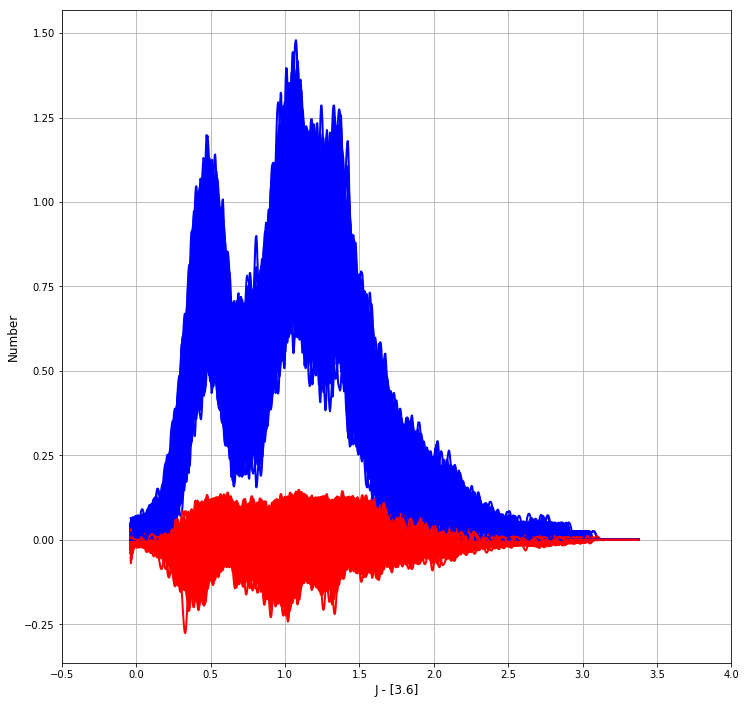

(0.8479456384384382, 0.32684605410927775)

In [20]:
# 20 (Bin 4)

def doplot(x, pdfx, deriv = 0, data = 0, first = True, last = False):
    if first: plt.figure(figsize = (12,12))
    plt.plot(x, pdfx, 'k', lw = 2, label = 'KDE', color='blue')
    #if len(data) != 1 and data[0] != 0:
    #    plt.hist(data, bins = bins, normed = True, label = 'Binned data')
    try:
        scale = np.max(pdfx)/np.max(deriv)/10.
        plt.plot(x, deriv*scale, 'r', lw = 2, label = 'dKDE', color='red')
    except:
        print('no derivatives specified')
    if last:
        plt.xlim(-0.5, 4.0)
        plt.xlabel('J - [3.6]', size=12)
        plt.ylabel('Number', size=12)
        plt.grid(True)
        plt.show()
        plt.close()
    #if len(deriv) != 1 and deriv[0] != 0:
    #    scale = np.max(pdfx)/np.max(deriv)
    #    print(scale)
    #    plt.plot(x, deriv*scale, 'k', lw = 3, label = 'dKDE')
    #    #plt.plot(x, deriv, 'r', lw = 2, label = 'dKDE')

def trgbfind(infile = 'jMINUSthreesix.csv', magname = 'k36mag', dmagname = 'e36mag', niter = 1000, kernel = 'epanechnikov'):

    #Read from input table into variables m and dm
#    m, dm = getdata(infile = infile)

    ### Can I skip all the "infile" stuff? -> YES!
    #m = jMINUSthreesixDATA.k36mag
    #dm = jMINUSthreesixDATA.e36mag

    ### Instead of TRGB, let's try the small range of magnitudes
    m = jMINUSthreesixHIST.jMINUSthreesix
    dm = jMINUSthreesixHIST.ERRORjMINUSthreesix
    
    #Initialise stuff
    niter = 1000
    rtol = 1e-5
    kernel = 'epanechnikov' #parabolic kernel
    mx = np.linspace(max(m)*1.2, min(m)*0.8, 1000)
    trgbloc = np.zeros(niter)
    #Generate NITER realisations of the KDE

    for i in range(niter):
        msamp = np.random.normal(m, dm)
        #PS: Monte Carlo already smooths the distribution, so reduce the ideal binwidth a bit.
        bandwidth_factor = 0.25
        bandwidth = bandwidth_factor*(np.std(msamp)*(len(msamp)**(-0.2)))
        #Requires you to define the BANDWIDTH and KERNEL variables before this line.
        kde = neighbors.KernelDensity(bandwidth = bandwidth, rtol = rtol, kernel = kernel)
        kde.fit(msamp[:, np.newaxis])
        #MX is the x axis range over which the PDF is computed/plotted.
        #kde.score_samples returns ln(pdf)
        pdf = np.exp(kde.score_samples(mx[:, np.newaxis]))
        smooth_window = 31
        poly_degree = 3
        dpdf = savgol_filter(pdf, smooth_window, poly_degree, deriv = 1)
        trgbloc[i] = mx[np.argmin(dpdf)] #Most negative value corresponds to highest rate of decrease 
        #Plotting
        doplot(mx, pdf, deriv = dpdf, data = msamp, first = i == 0, last = i == niter - 1)
        #Use PDF to do stuff (e.g., detect edges)
        #result = do_stuff(pdf)
        #Store results of ith iteration
        #
        #

    trgbloc_mean = np.mean(trgbloc)
    trgbloc_sd = np.std(trgbloc)
    return trgbloc_mean, trgbloc_sd
    #print(trgbloc_mean, trgbloc_sd) # this does the same as the above, just differently

trgbfind()


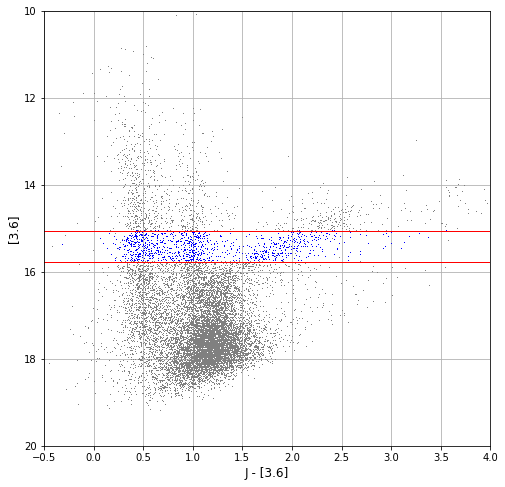

1011
0.2041578947368421
15.764
15.064


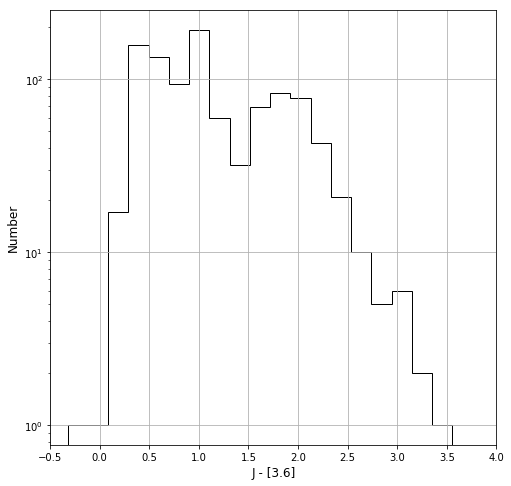

In [73]:
# 21 (Bin 5)

# Here I'm making the CMD of *ONLY* the sources within the fifth bin above the TRGB.
# Also I'm making a histogram of said sources.

#TRGB = 17.386
#initial_width = 0.500
#width_change = 0.010

TRGB = 15.764

jMINUSthreesixHIST = low_error_jMINUSthreesixDATA[(low_error_jMINUSthreesixDATA.k36mag < (TRGB))
                                    & (low_error_jMINUSthreesixDATA.k36mag > (TRGB-initial_width*1.-width_change*20.))]

bin_end = TRGB-initial_width*1.-width_change*20.

plt.figure(figsize=(8,8))
plt.plot(jMINUSthreesixDATA.jMINUSthreesix, jMINUSthreesixDATA.k36mag, ',', color='gray')
plt.plot(jMINUSthreesixHIST.jMINUSthreesix, jMINUSthreesixHIST.k36mag, ',', color='blue')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('[3.6]', size=12)
#
plt.axhline(y=TRGB, linewidth=1.0, color='red') # Bin 5 - lower boundary
plt.axhline(y=bin_end, linewidth=1.0, color='red') # Bin 5 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
#print jMINUSthreesixHIST
print(len(jMINUSthreesixHIST))
#
binwidth = stats.knuth_bin_width(jMINUSthreesixHIST.jMINUSthreesix)
bin_number = (max(jMINUSthreesixHIST.jMINUSthreesix)+binwidth)/binwidth
print(binwidth)
#print bin_number
#
print(TRGB)
print(bin_end)
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSthreesixHIST.jMINUSthreesix, bins=np.arange(min(jMINUSthreesixHIST.jMINUSthreesix), max(jMINUSthreesixHIST.jMINUSthreesix) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

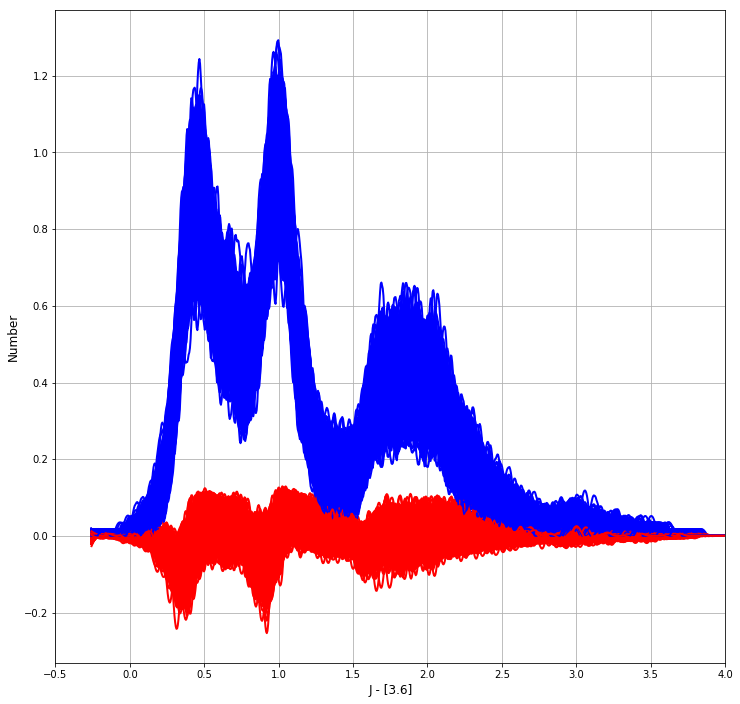

(0.5636311471471468, 0.30354193611127)

In [74]:
# 22 (Bin 5)

def doplot(x, pdfx, deriv = 0, data = 0, first = True, last = False):
    if first: plt.figure(figsize = (12,12))
    plt.plot(x, pdfx, 'k', lw = 2, label = 'KDE', color='blue')
    #if len(data) != 1 and data[0] != 0:
    #    plt.hist(data, bins = bins, normed = True, label = 'Binned data')
    try:
        scale = np.max(pdfx)/np.max(deriv)/10.
        plt.plot(x, deriv*scale, 'r', lw = 2, label = 'dKDE', color='red')
    except:
        print('no derivatives specified')
    if last:
        plt.xlim(-0.5, 4.0)
        plt.xlabel('J - [3.6]', size=12)
        plt.ylabel('Number', size=12)
        plt.grid(True)
        plt.show()
        plt.close()
    #if len(deriv) != 1 and deriv[0] != 0:
    #    scale = np.max(pdfx)/np.max(deriv)
    #    print(scale)
    #    plt.plot(x, deriv*scale, 'k', lw = 3, label = 'dKDE')
    #    #plt.plot(x, deriv, 'r', lw = 2, label = 'dKDE')

def trgbfind(infile = 'jMINUSthreesix.csv', magname = 'k36mag', dmagname = 'e36mag', niter = 1000, kernel = 'epanechnikov'):

    #Read from input table into variables m and dm
#    m, dm = getdata(infile = infile)

    ### Can I skip all the "infile" stuff? -> YES!
    #m = jMINUSthreesixDATA.k36mag
    #dm = jMINUSthreesixDATA.e36mag

    ### Instead of TRGB, let's try the small range of magnitudes
    m = jMINUSthreesixHIST.jMINUSthreesix
    dm = jMINUSthreesixHIST.ERRORjMINUSthreesix
    
    #Initialise stuff
    niter = 1000
    rtol = 1e-5
    kernel = 'epanechnikov' #parabolic kernel
    mx = np.linspace(max(m)*1.2, min(m)*0.8, 1000)
    trgbloc = np.zeros(niter)
    #Generate NITER realisations of the KDE

    for i in range(niter):
        msamp = np.random.normal(m, dm)
        #PS: Monte Carlo already smooths the distribution, so reduce the ideal binwidth a bit.
        bandwidth_factor = 0.25
        bandwidth = bandwidth_factor*(np.std(msamp)*(len(msamp)**(-0.2)))
        #Requires you to define the BANDWIDTH and KERNEL variables before this line.
        kde = neighbors.KernelDensity(bandwidth = bandwidth, rtol = rtol, kernel = kernel)
        kde.fit(msamp[:, np.newaxis])
        #MX is the x axis range over which the PDF is computed/plotted.
        #kde.score_samples returns ln(pdf)
        pdf = np.exp(kde.score_samples(mx[:, np.newaxis]))
        smooth_window = 31
        poly_degree = 3
        dpdf = savgol_filter(pdf, smooth_window, poly_degree, deriv = 1)
        trgbloc[i] = mx[np.argmin(dpdf)] #Most negative value corresponds to highest rate of decrease 
        #Plotting
        doplot(mx, pdf, deriv = dpdf, data = msamp, first = i == 0, last = i == niter - 1)
        #Use PDF to do stuff (e.g., detect edges)
        #result = do_stuff(pdf)
        #Store results of ith iteration
        #
        #

    trgbloc_mean = np.mean(trgbloc)
    trgbloc_sd = np.std(trgbloc)
    return trgbloc_mean, trgbloc_sd
    #print(trgbloc_mean, trgbloc_sd) # this does the same as the above, just differently

trgbfind()


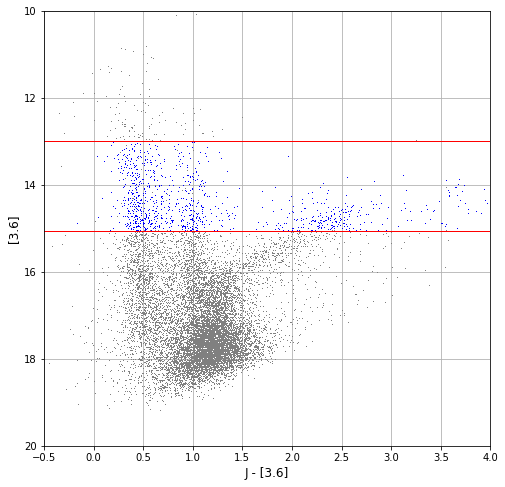

979
0.25636363636363635
15.064
14.274000000000001


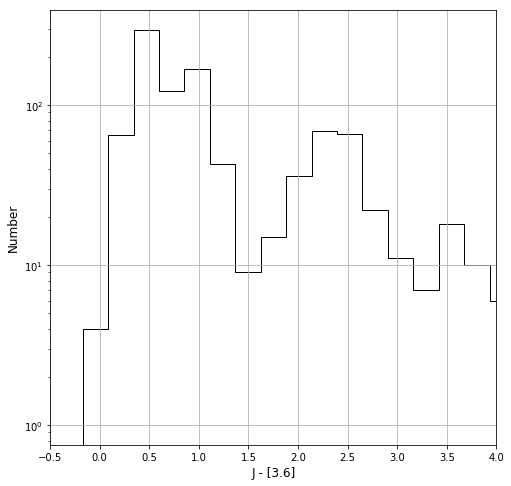

In [23]:
# 23 (Bin 6)

# Here I'm making the CMD of *ONLY* the sources within the sixth bin above the TRGB.
# Also I'm making a histogram of said sources.

#TRGB = 17.386
#initial_width = 0.500
#width_change = 0.010

TRGB = 15.064

jMINUSthreesixHIST = low_error_jMINUSthreesixDATA[(low_error_jMINUSthreesixDATA.k36mag < (TRGB))
                                    & (low_error_jMINUSthreesixDATA.k36mag > 13.)]

bin_end = TRGB-initial_width*1.-width_change*29.

plt.figure(figsize=(8,8))
plt.plot(jMINUSthreesixDATA.jMINUSthreesix, jMINUSthreesixDATA.k36mag, ',', color='gray')
plt.plot(jMINUSthreesixHIST.jMINUSthreesix, jMINUSthreesixHIST.k36mag, ',', color='blue')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('[3.6]', size=12)
#
plt.axhline(y=TRGB, linewidth=1.0, color='red') # Bin 6 - lower boundary
plt.axhline(y=13.0, linewidth=1.0, color='red') # Bin 6 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
#print jMINUSthreesixHIST
print(len(jMINUSthreesixHIST))
#
binwidth = stats.knuth_bin_width(jMINUSthreesixHIST.jMINUSthreesix)
bin_number = (max(jMINUSthreesixHIST.jMINUSthreesix)+binwidth)/binwidth
print(binwidth)
#print bin_number
#
print(TRGB)
print(bin_end)
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSthreesixHIST.jMINUSthreesix, bins=np.arange(min(jMINUSthreesixHIST.jMINUSthreesix), max(jMINUSthreesixHIST.jMINUSthreesix) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
plt.xlabel('J - [3.6]', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

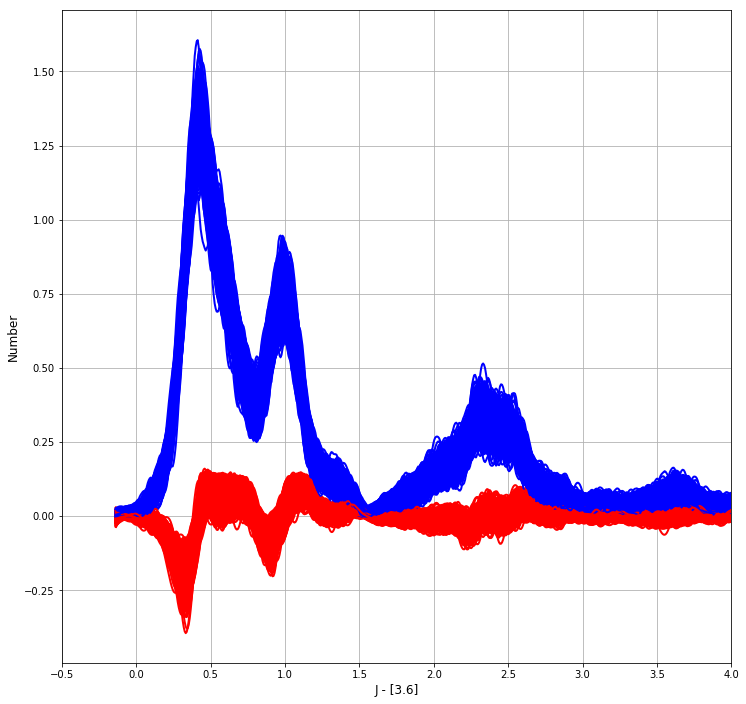

(0.3240841945945948, 0.0323059028492122)

In [24]:
# 24 (Bin 6)

def doplot(x, pdfx, deriv = 0, data = 0, first = True, last = False):
    if first: plt.figure(figsize = (12,12))
    plt.plot(x, pdfx, 'k', lw = 2, label = 'KDE', color='blue')
    #if len(data) != 1 and data[0] != 0:
    #    plt.hist(data, bins = bins, normed = True, label = 'Binned data')
    try:
        scale = np.max(pdfx)/np.max(deriv)/10.
        plt.plot(x, deriv*scale, 'r', lw = 2, label = 'dKDE', color='red')
    except:
        print('no derivatives specified')
    if last:
        plt.xlim(-0.5, 4.0)
        plt.xlabel('J - [3.6]', size=12)
        plt.ylabel('Number', size=12)
        plt.grid(True)
        plt.show()
        plt.close()
    #if len(deriv) != 1 and deriv[0] != 0:
    #    scale = np.max(pdfx)/np.max(deriv)
    #    print(scale)
    #    plt.plot(x, deriv*scale, 'k', lw = 3, label = 'dKDE')
    #    #plt.plot(x, deriv, 'r', lw = 2, label = 'dKDE')

def trgbfind(infile = 'jMINUSthreesix.csv', magname = 'k36mag', dmagname = 'e36mag', niter = 1000, kernel = 'epanechnikov'):

    #Read from input table into variables m and dm
#    m, dm = getdata(infile = infile)

    ### Can I skip all the "infile" stuff? -> YES!
    #m = jMINUSthreesixDATA.k36mag
    #dm = jMINUSthreesixDATA.e36mag

    ### Instead of TRGB, let's try the small range of magnitudes
    m = jMINUSthreesixHIST.jMINUSthreesix
    dm = jMINUSthreesixHIST.ERRORjMINUSthreesix
    
    #Initialise stuff
    niter = 1000
    rtol = 1e-5
    kernel = 'epanechnikov' #parabolic kernel
    mx = np.linspace(max(m)*1.2, min(m)*0.8, 1000)
    trgbloc = np.zeros(niter)
    #Generate NITER realisations of the KDE

    for i in range(niter):
        msamp = np.random.normal(m, dm)
        #PS: Monte Carlo already smooths the distribution, so reduce the ideal binwidth a bit.
        bandwidth_factor = 0.25
        bandwidth = bandwidth_factor*(np.std(msamp)*(len(msamp)**(-0.2)))
        #Requires you to define the BANDWIDTH and KERNEL variables before this line.
        kde = neighbors.KernelDensity(bandwidth = bandwidth, rtol = rtol, kernel = kernel)
        kde.fit(msamp[:, np.newaxis])
        #MX is the x axis range over which the PDF is computed/plotted.
        #kde.score_samples returns ln(pdf)
        pdf = np.exp(kde.score_samples(mx[:, np.newaxis]))
        smooth_window = 31
        poly_degree = 3
        dpdf = savgol_filter(pdf, smooth_window, poly_degree, deriv = 1)
        trgbloc[i] = mx[np.argmin(dpdf)] #Most negative value corresponds to highest rate of decrease 
        #Plotting
        doplot(mx, pdf, deriv = dpdf, data = msamp, first = i == 0, last = i == niter - 1)
        #Use PDF to do stuff (e.g., detect edges)
        #result = do_stuff(pdf)
        #Store results of ith iteration
        #
        #

    trgbloc_mean = np.mean(trgbloc)
    trgbloc_sd = np.std(trgbloc)
    return trgbloc_mean, trgbloc_sd
    #print(trgbloc_mean, trgbloc_sd) # this does the same as the above, just differently

trgbfind()
